# **Probabilistic Outputs for Support Vector Machines and Comparisons to Regularized Likelihood Methods**

This method is used for **converting raw SVM decision function outputs into well-calibrated probability estimates** using **Platt Scaling**.

## **Overview**
- SVMs provide a **decision function output** that does not directly represent probabilities.
- Platt Scaling fits a **sigmoid function** to the SVM scores to produce probabilistic outputs.

## **Mathematical Formulation**
The probability of a sample belonging to class **\( y = 1 \)** given its SVM score \( f(x) \) is computed as:

$$
P(y=1 | f) = \frac{1}{1 + e^{A f + B}}
$$

where:
- \( A \) and \( B \) are parameters optimized using **Maximum Likelihood Estimation (MLE)**.
- \( f(x) = w^T x + b \) is the **raw decision function output from SVM**.

### **Maximum Likelihood Estimation (MLE)**
The parameters \( A \) and \( B \) are learned by **minimizing the negative log-likelihood function**, given by:

$$
L(A, B) = - \sum_{i} \left[ t_i \log p_i + (1 - t_i) \log (1 - p_i) \right]
$$

where:
- \( t_i \) represents the target values (mapped from original labels).
- \( p_i \) is the estimated probability computed as:

  $$
  p_i = \frac{1}{1 + e^{A f_i + B}}
  $$

To find the optimal values of \( A \) and \( B \), we solve:

$$
\frac{\partial L}{\partial A} = 0, \quad \frac{\partial L}{\partial B} = 0
$$

using **Newton-Raphson iteration**.

### **Newton-Raphson Update for \( A \) and \( B \)**
Newton’s method updates \( A \) and \( B \) iteratively using:

$$
\begin{bmatrix} A \\ B \end{bmatrix} =
\begin{bmatrix} A \\ B \end{bmatrix} - H^{-1} G
$$

where:
- **Gradient vector \( G \)**:

  $$
  G =
  \begin{bmatrix}
  \sum_i x_i (p_i - t_i) \\
  \sum_i (p_i - t_i)
  \end{bmatrix}
  $$

- **Hessian matrix \( H \)**:

  $$
  H =
  \begin{bmatrix}
  \sum_i x_i^2 p_i (1 - p_i) & \sum_i x_i p_i (1 - p_i) \\
  \sum_i x_i p_i (1 - p_i) & \sum_i p_i (1 - p_i)
  \end{bmatrix}
  $$

The update equations for \( A \) and \( B \) are:

$$
A = A + \frac{(b + \lambda) d - c e}{\det(H)}
$$

$$
B = B + \frac{(a + \lambda) e - c d}{\det(H)}
$$

where:
- \( a, b, c \) are Hessian elements.
- \( d, e \) are gradient components.
- \( \lambda \) is a small regularization term to prevent singularity.

## **Steps in the Method**
1. **Train an SVM**: Compute the decision function \( f(x) \).
2. **Fit a sigmoid function**: Optimize \( A \) and \( B \) using a validation set.
3. **Convert scores into probabilities**: Use the learned sigmoid function to generate calibrated probabilities.

## **Why Is This Useful?**
- **Probability calibration**: Ensures SVM scores are interpretable as confidence values.
- **Better decision-making**: Useful in applications like medical diagnosis, fraud detection, and risk assessment.
- **Comparison with other probabilistic models**: Helps evaluate SVM performance against logistic regression and other likelihood-based methods.



In [3]:
import numpy as np

def safe_log(val):
    if val == 0:
        return -200
    else:
        return np.log(val)

def sigmoid_transform(score, scale_factor=1, shift_factor=6.6451537894926167):
    return 1 / (1 + np.exp(score * scale_factor + shift_factor))

def calibrate_scores(score_array, label_array):
    """
    Fits a sigmoid function to the classifier's raw scores using the Platt Scaling method.
    
    Input:
        score_array - Array-like, raw classifier scores.
        label_array - Array-like, classifier labels (+1/-1 or +1/0).
    
    Output:
        Optimized scale factor and shift factor (A and B) for probability transformation.
    """
    scores = np.array(score_array)
    labels = np.array(label_array)
    assert len(scores) == len(labels)
    
    is_positive = labels == 1
    positive_count = float(np.sum(is_positive))
    negative_count = len(labels) - positive_count

    scale_factor = 0
    shift_factor = np.log((negative_count + 1) / (positive_count + 1))

    upper_target = (positive_count + 1) / (positive_count + 2)
    lower_target = 1 / (negative_count + 2)

    regularization = 1e-3
    prev_error = 1e300
    estimated_prob = np.ones(scores.shape) * (positive_count + 1) / (negative_count + positive_count + 2)

    target_values = np.zeros(is_positive.shape)
    
    for iteration in range(1, 100):
        sum_a = 0
        sum_b = 0
        sum_c = 0
        sum_d = 0
        sum_e = 0

        for idx in range(len(scores)):
            if is_positive[idx]:
                target = upper_target
                target_values[idx] = target
            else:
                target = lower_target
                target_values[idx] = target

            diff1 = estimated_prob[idx] - target
            diff2 = estimated_prob[idx] * (1 - estimated_prob[idx])

            sum_a += scores[idx] * scores[idx] * diff2
            sum_b += diff2
            sum_c += scores[idx] * diff2
            sum_d += scores[idx] * diff1
            sum_e += diff1

        if abs(sum_d) < 1e-9 and abs(sum_e) < 1e-9:
            break

        prev_scale_factor = scale_factor
        prev_shift_factor = shift_factor
        error_value = 0
        stabilization_count = 0

        while True:
            determinant = (sum_a + regularization) * (sum_b + regularization) - sum_c * sum_c
            if determinant == 0:
                regularization *= 10
                continue

            scale_factor = prev_scale_factor + ((sum_b + regularization) * sum_d - sum_c * sum_e) / determinant
            shift_factor = prev_shift_factor + ((sum_a + regularization) * sum_e - sum_c * sum_d) / determinant

            error_value = 0
            for idx in range(len(scores)):
                probability = sigmoid_transform(scores[idx], scale_factor, shift_factor)
                estimated_prob[idx] = probability
                target = target_values[idx]
                error_value -= target * safe_log(probability) + (1 - target) * safe_log(1 - probability)

            if error_value > 1e6:
                break

            error_diff = error_value - prev_error
            scaling_factor = 0.5 * (error_value + prev_error + 1)

            if -1e-3 * scaling_factor < error_diff < 1e-7 * scaling_factor:
                stabilization_count += 1
            else:
                stabilization_count = 0

            prev_error = error_value

            if stabilization_count == 3:
                break

    return scale_factor, shift_factor

if __name__ == '__main__':
    raw_scores = 3 * (2 * np.random.rand(100) - 1)  # Values ranging from -3 to 3
    generated_labels = 2 * ((raw_scores + 2 * np.random.rand(len(raw_scores)) - 1) > 0) - 1  # Assigning +1 and -1 labels

    scale, shift = calibrate_scores(raw_scores, generated_labels)  # Compute sigmoid parameters
    print('Factor (A) =', scale, 'Factor (B) =', shift)

    calibrated_probs = sigmoid_transform(raw_scores, scale, shift)

    from sklearn.metrics import roc_auc_score
    print("Score Ranges:")
    print("Before Scaling:", np.min(raw_scores), np.max(raw_scores))
    print("After Scaling:", np.min(calibrated_probs), np.max(calibrated_probs))

    print("Verifying AUC-ROC (should remain unchanged):")
    print(roc_auc_score(generated_labels, calibrated_probs))
    print(roc_auc_score(generated_labels, raw_scores))


Factor (A) = -2.4988310623953334 Factor (B) = -0.08706606584926871
Score Ranges:
Before Scaling: -2.9568618805118607 2.927470402341809
After Scaling: 0.0006739824687927306 0.9993905354004505
Verifying AUC-ROC (should remain unchanged):
0.9927971188475391
0.9927971188475391


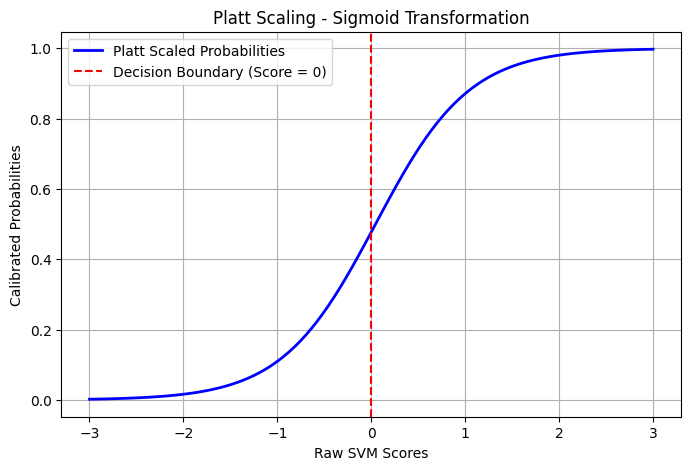

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define sigmoid function with Platt Scaling parameters
def sigmoid_transform(score, scale_factor, shift_factor):
    return 1 / (1 + np.exp(score * scale_factor + shift_factor))

# Generate synthetic classifier scores
raw_scores = np.linspace(-3, 3, 100) 
scale_factor = -2.0019072205117525 
shift_factor = 0.09033390280202017  

# Apply Platt Scaling
calibrated_probs = sigmoid_transform(raw_scores, scale_factor, shift_factor)

# Plot the transformation
plt.figure(figsize=(8, 5))
plt.plot(raw_scores, calibrated_probs, label="Platt Scaled Probabilities", color='blue', linewidth=2)
plt.axvline(0, color='red', linestyle='--', label="Decision Boundary (Score = 0)")
plt.xlabel("Raw SVM Scores")
plt.ylabel("Calibrated Probabilities")
plt.title("Platt Scaling - Sigmoid Transformation")
plt.legend()
plt.grid(True)
plt.show()
